In [2]:
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
####################you will need to change some paths here!#####################
#list of input directories
dir_storm_info='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
dir_flux = 'F:/data/model_data/oaflux/data_v3/daily/turbulence/'
dir_cmc = 'F:/data/sst/cmc/CMC0.2deg/v2/'
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
##where to get the data through opendap, use these directories instead
#dir_cmc = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/CMC/CMC0.1deg/v3/'
#dir_flux = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WHOI_OAFlux/version3/daily/lh_oaflux/'
#the latest ccmp is from www.remss.com but they do not have an opendap server so you can use this instead:
#dir_ccmp='https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/'

#################################################################################
import geopy.distance
from math import sin, pi
from scipy import interpolate
import sys

#functions for running storm data
def interpolate_storm_path(dsx):
    #after calculating the distance from the storm it became clear that the storm data is every 6 hours, no matter 
    #how much it may have moved.  So if the storm moved 300 km in 6 hr, when calculating the distance to the storm
    #there were points on the storm track that showed large distances because of the separation to the 6hrly storm points
    #this subroutine interpolates the storm path onto a higher spatial resolution
    #the new storm dataset is carefully put into an identical format with i2 and j2 as dims to match the old format
    ynew = []
    tnew = []
    xnew = []
    dsx['lon'] = (dsx.lon-180) % 360 - 180 #put -180 to 180
    for istep in range(1,dsx.lon.shape[1]):
        dif_lat = dsx.lat[0,istep]-dsx.lat[0,istep-1]
        dif_lon = dsx.lon[0,istep]-dsx.lon[0,istep-1]
        x,y,t = dsx.lon[0,istep-1:istep+1].values,dsx.lat[0,istep-1:istep+1].values,dsx.time[0,istep-1:istep+1].values
        x1,y1,t1 = dsx.lon[0,istep-1:istep].values,dsx.lat[0,istep-1:istep].values,dsx.time[0,istep-1:istep].values
        if abs(dif_lat)>abs(dif_lon):
            isign = np.sign(dif_lat)
            if abs(dif_lat)>0.75:
                ynew1 = np.arange(y[0], y[-1], isign.data*0.75)
                f = interpolate.interp1d(y, x, assume_sorted=False)
                xnew1 = f(ynew1)
                f = interpolate.interp1d(y, t, assume_sorted=False)
                tnew1 = f(ynew1)
            else:
                xnew1,ynew1,tnew1 = x1,y1,t1
            xnew,ynew,tnew = np.append(xnew,xnew1),np.append(ynew,ynew1),np.append(tnew,tnew1) 
        else:
            isign = np.sign(dif_lon)
            if abs(dif_lon)>0.75:
                iwrap_interp = 1
                if (x[0]<-90) & (x[-1]>90):
                    iwrap_interp = -1
                    x[0]=x[0]+360
                if (x[0]>90) & (x[-1]<-90):
                    iwrap_interp = -1
                    x[-1]=x[-1]+360
                xnew1 = np.arange(x[0], x[-1], iwrap_interp*isign.data*0.75)
                f = interpolate.interp1d(x, y, assume_sorted=False)
                ynew1 = f(xnew1)
                f = interpolate.interp1d(x, t, assume_sorted=False)
                tnew1 = f(xnew1)
                xnew1 = (xnew1 - 180) % 360 - 180 #put -180 to 180
            else:
                xnew1,ynew1,tnew1 = x1,y1,t1
            xnew,ynew,tnew = np.append(xnew,xnew1),np.append(ynew,ynew1),np.append(tnew,tnew1) 
#remove any repeated points
    ilen=xnew.size
    outputx,outputy,outputt=[],[],[]
    for i in range(ilen-1):
        if (xnew[i]==xnew[i+1]) and (ynew[i]==ynew[i+1]):
            continue
        else:
            outputx,outputy,outputt = np.append(outputx,xnew[i]),np.append(outputy,ynew[i]),np.append(outputt,tnew[i])
    xnew,ynew,tnew=outputx,outputy,outputt
#put into xarray
    i2,j2=xnew.shape[0],1
    tem = np.expand_dims(xnew, axis=0)
    xx = xr.DataArray(tem.T,dims=['i2','j2'])
    tem = np.expand_dims(ynew, axis=0)
    yy = xr.DataArray(tem.T,dims=['i2','j2'])
    tem = np.expand_dims(tnew, axis=0)
    tt = xr.DataArray(tem.T,dims=['i2','j2'])
    dsx_new = xr.Dataset({'lon':xx.T,'lat':yy.T,'time':tt.T})
    return dsx_new

def get_dist_grid(lat_point,lon_point,lat_grid,lon_grid):
    #this routine takes a point and finds distance to all points in a grid of lat and lon
    #it is slowwwwwww
    dist_grid = np.empty(lat_grid.shape)    
    coords_1 = (lat_point, lon_point)  
    for i in range(0,lat_grid.shape[0]):
        for j in range(0,lat_grid.shape[1]):
            coords_2 = (lat_grid[i,j], lon_grid[i,j])  
            arclen_temp = geopy.distance.geodesic(coords_1, coords_2).km  #distance in km       
            dist_grid[i,j]=arclen_temp
    return dist_grid


def closest_dist(ds_in,ds_storm): 
# m.garcia-reyes 2.4.2019, edited c.gentemann 2.4.2019
# calculate distance closest storm point
# point given as tla,tlo.... storm is in the program
# initialize distances (in km)
    ds_storm['lon'] = (ds_storm.lon + 180) % 360 - 180
    dsx_input = ds_storm.copy(deep=True)
    ds_storm_new = interpolate_storm_path(dsx_input)       
    tdim,xdim,ydim=ds_storm_new.lat.shape[1], ds_in.analysed_sst[0,:,0].shape[0], ds_in.analysed_sst[0,0,:].shape[0]
    dx_save=np.zeros([tdim,xdim,ydim])
    dx_grid,dy_grid = np.meshgrid(ds_in.lon.values,ds_in.lat.values)
    lon_grid,lat_grid = np.meshgrid(ds_in.lon.values,ds_in.lat.values)
    min_dist_save = np.zeros([xdim,ydim])*np.nan
    min_index_save = np.zeros([xdim,ydim])*np.nan
    min_time_save = np.zeros([xdim,ydim])*np.nan

    position = np.zeros([xdim,ydim])*np.nan
    #for each location of the storm calculate the difference for all values in box
    for ipt in range(0,ds_storm_new.lat.shape[1]):  # all storm values
        dist_tem_grid = get_dist_grid(ds_storm_new.lat[0,ipt].values,ds_storm_new.lon[0,ipt].values,lat_grid,lon_grid)
        dx_save[ipt,:,:]=dist_tem_grid       
    #now go through each value in box and find minimum storm location/day
    for j in range(0,ds_in.lon.shape[0]):
        for i in range(0,ds_in.lat.shape[0]):
            imin = np.argmin(dx_save[:,i,j])
            min_dist_save[i,j]=dx_save[imin,i,j]
            min_index_save[i,j]=imin
            min_time_save[i,j]=ds_storm_new.time[0,imin]
            i1,i2=imin,imin+1
            if i2>=ds_storm_new.lat.shape[1]:
                i1,i2=imin-1,imin
            lonx,laty=ds_in.lon[j],ds_in.lat[i]
    #                sign((Bx - Ax) * (Y - Ay) - (By - Ay) * (X - Ax))
            position[i,j] = np.sign((ds_storm_new.lon[0,i2] - ds_storm_new.lon[0,i1]) * (laty - ds_storm_new.lat[0,i1]) 
                                 - (ds_storm_new.lat[0,i2] - ds_storm_new.lat[0,i1]) * (lonx - ds_storm_new.lon[0,i1]))

    return min_dist_save,min_index_save,min_time_save,position,ds_storm_new

def calculate_storm_mask(ds_sst,lats,lons):
#make a mask for the storm and only keep data within -4 and 10 degrees of storm track
#this was written before I had calculated the closest_dist which is probably a better mask to use
    iwrap_mask = 0
    if (ds_sst.lon.max().values>170) & (ds_sst.lon.min().values<-170):
        iwrap_mask=1
    print(ds_sst.lon.min().values,ds_sst.lon.max().values)
#okay, now ds_storm is array with right lat/lon for storm so create mask now
    ds_mask = ds_sst.copy(deep=True)
    ds_mask['storm_mask']=ds_mask.analysed_sst*0
    ds_mask = ds_mask.fillna(0)
    ds_mask['storm_mask'] = ds_mask['storm_mask'].astype(int,copy=True)
    for i in range(0,lats.shape[0]):
        if lats[i]>0:   #northern hemi on right, southers on left
            lons1,lons2=lons[i]-4,lons[i]+10
        else:
            lons1,lons2=lons[i]-10,lons[i]+4
        lats1,lats2=lats[i]-10,lats[i]+10
        if i==0:
            print('lons1,lons2:',iwrap_mask,lons1.data,lons2.data)
        if lons1<-180:
            ds_mask['storm_mask'].loc[dict(lon=(ds_mask.lon < lons2) | (ds_mask.lon > lons1+360), lat=slice(lats1,lats2))] = -1
        elif lons2>180:
            ds_mask['storm_mask'].loc[dict(lon=(ds_mask.lon < lons2-360) | (ds_mask.lon > lons1), lat=slice(lats1,lats2))] = -1
        else:
            if iwrap_mask==1:
                ds_mask.coords['lon'] = np.mod(ds_mask['lon'], 360)
                ds_mask = ds_mask.sortby(ds_mask.lon)
                ds_mask['storm_mask'].loc[dict(lon=slice(lons1+360,lons2+360), lat=slice(lats1,lats2))] = -1
                ds_mask.coords['lon'] = (ds_mask.coords['lon'] + 180) % 360 - 180
            else:
                ds_mask['storm_mask'].loc[dict(lon=slice(lons1,lons2), lat=slice(lats1,lats2))] = -1
    return ds_mask



In [ ]:

input_year=int(str(sys.argv[1]))
print ('processing year:', input_year)


In [ ]:
isave_mld_year = 0 #init MLD monthly data read flag
for root, dirs, files in os.walk(dir_storm_info, topdown=False):
    if root[len(dir_storm_info):len(dir_storm_info)+1]=='.':
        continue
    for name in files:
        if not name.endswith('.nc'):
            continue
        filename=os.path.join(root, name)
        print(filename[36:39],filename[31:35])
        inum_storm=int(filename[36:39])
        iyr_storm=int(filename[31:35])

        
        if iyr_storm!=input_year:
            continue
        if iyr_storm==2002 and inum_storm<9:
            continue
        
        
#        if iyr_storm!=2007: # or iyr_storm<2003:
#            continue
        print(name,filename)
        ds_storm_info = xr.open_dataset(filename)
        lats = ds_storm_info.lat[0,:]
        lons = ds_storm_info.lon[0,:]  #lons goes from 0 to 360
        lons = (lons + 180) % 360 - 180 #put -180 to 180
        dysince = ds_storm_info.time
        ds_storm_info.close()
        
#make lat and lon of storm onto 25 km grid for below
        lons = (((lons - .125)/.25+1).astype(int)-1)*.25+.125
        lats = (((lats + 89.875)/.25+1).astype(int)-1)*.25-89.875
        
        iwrap=0
#calculate size of box to get data in
        minlon,maxlon = min(lons.values)-10, max(lons.values)+10
        minlat,maxlat = min(lats.values)-10, max(lats.values)+10

        ydim_storm = round((maxlat - minlat)/.25).astype(int)
        new_lat_storm = np.linspace(minlat, maxlat, ydim_storm)
        if (minlon<-90 and maxlon>=90) or (minlon<-180 and maxlon<0):  #this storm wraps  keep everythig 0 to 360 then wrap data at very end
            iwrap = 1
            lons2 = np.mod(lons, 360)
            minlon, maxlon = min(lons2.values)-10, max(lons2.values)+10
            xdim_storm = round((maxlon - minlon)/.25).astype(int)
            new_lon_storm = np.linspace(minlon, maxlon, xdim_storm)
        else:
            xdim_storm = round((maxlon - minlon)/.25).astype(int)
            new_lon_storm = np.linspace(minlon, maxlon, xdim_storm)

        print(iwrap,minlon,maxlon)
        print(iwrap,xdim_storm, new_lon_storm[:5],new_lon_storm[-5:])

        
        date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
        dims=lats.shape
        tdim=dims[0]
        tem_date=[0]*tdim #print(dysince.values)
        for i in range(0,tdim):
            tem_date[i]=date_1858+dt.timedelta(days=float(dysince[0,i].values))  #create new time array that can be queried for year etc
        min_date = min(tem_date)+dt.timedelta(days=-5)
        max_date = max(tem_date)+dt.timedelta(days=5)
        minjdy = min_date.timetuple().tm_yday  #create new time array that can be queried for year etc
        minyear =min_date.year #create new time array that can be queried for year etc
        minmon =min_date.month #create new time array that can be queried for year etc
        minday =min_date.day #create new time array that can be queried for year etc
        maxjdy = max_date.timetuple().tm_yday  #create new time array that can be queried for year etc
        maxyear =max_date.year  #create new time array that can be queried for year etc
        print(minyear,minjdy,maxyear,maxjdy)
        
        dif = max(tem_date)-min(tem_date)
        tdim=int(dif.days)+30             #calculate ssts for 30 days after storm

        #print(tdim,xdim,ydim)            
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
        ds_all = xr.open_dataset(filename,drop_variables=['uwnd','vwnd','dbss_obml','lhtfl','shtfl','tmp2m ','hum2m','analysed_sst_clim'])
        ds_all.close()
        
#        ds_all = xr.merge([ds_storm_ccmp, ds_storm_mld, ds_storm_lhf, ds_storm_shf, ds_storm_ta, ds_storm_qa, ds_storm_sst])

        #calculate mask
        print('caluculating mask')
        ds_mask = calculate_storm_mask(ds_all,lats,lons)
        ds_all['storm_mask']=ds_mask['storm_mask']
        #dist to storm
        print('calculating dist')
        dist,index,stime,position,ds_storm_interp = closest_dist(ds_all,ds_storm_info)
        dtem=xr.DataArray(dist, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['dist_from_storm_km']=dtem
        dtem=xr.DataArray(index, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['closest_storm_index']=dtem
        dtem=xr.DataArray(stime, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['closest_storm_time']=dtem
        dtem=xr.DataArray(position, coords={'lat': ds_mask.lat.values, 'lon':ds_mask.lon.values}, dims=('lat', 'lon'))
        ds_all['side_of_storm']=dtem

        
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined__masking_data.nc'
        ds_all.to_netcdf(filename)
        print('out:',filename)
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
        ds_storm_interp.to_netcdf(filename)
        print('out:',filename)
    


f:/data/tc_wakes/database/sst/2003/002_interpolated_track.nc
38.375 88.125
f:/data/tc_wakes/database/sst/2003/003_interpolated_track.nc
171.625 -123.875
f:/data/tc_wakes/database/sst/2003/004_interpolated_track.nc
49.375 99.125
f:/data/tc_wakes/database/sst/2003/005_interpolated_track.nc
157.875 -165.375
f:/data/tc_wakes/database/sst/2003/006_interpolated_track.nc
23.625 60.125
f:/data/tc_wakes/database/sst/2003/008_interpolated_track.nc
107.875 147.375
f:/data/tc_wakes/database/sst/2003/009_interpolated_track.nc
59.375 89.125
f:/data/tc_wakes/database/sst/2003/010_interpolated_track.nc
136.375 172.875
f:/data/tc_wakes/database/sst/2003/011_interpolated_track.nc
169.625 -128.875
f:/data/tc_wakes/database/sst/2003/012_interpolated_track.nc
150.375 178.875
f:/data/tc_wakes/database/sst/2003/013_interpolated_track.nc
32.375 77.875
f:/data/tc_wakes/database/sst/2003/015_interpolated_track.nc
80.875 127.375
f:/data/tc_wakes/database/sst/2003/016_interpolated_track.nc
71.375 99.125
f:/data/t

C:\Users\gentemann\Miniconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


f:/data/tc_wakes/database/sst/2003/026_interpolated_track.nc
161.875 -144.875


C:\Users\gentemann\Miniconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


f:/data/tc_wakes/database/sst/2003/027_interpolated_track.nc
102.625 133.875


C:\Users\gentemann\Miniconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


f:/data/tc_wakes/database/sst/2003/028_interpolated_track.nc
112.125 170.125


C:\Users\gentemann\Miniconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


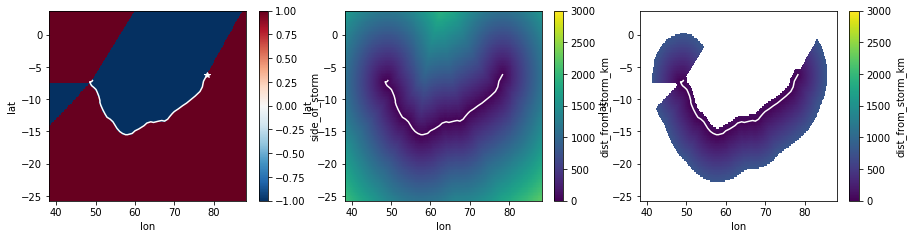

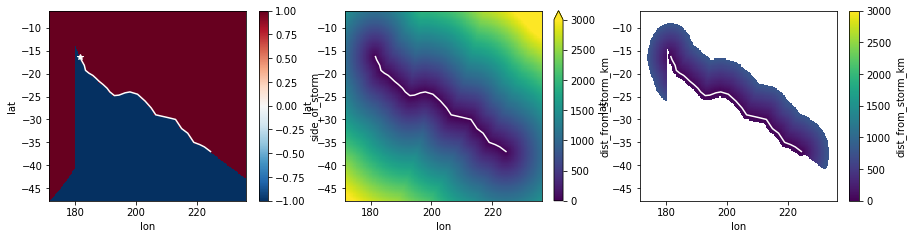

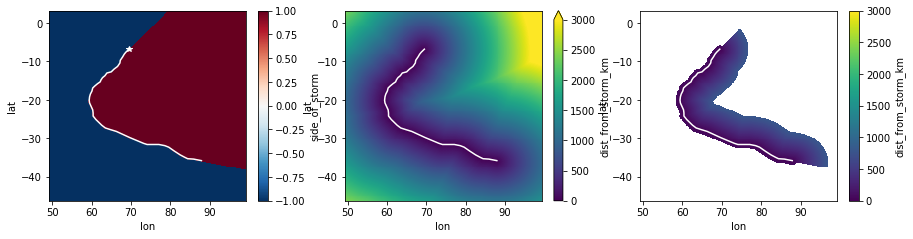

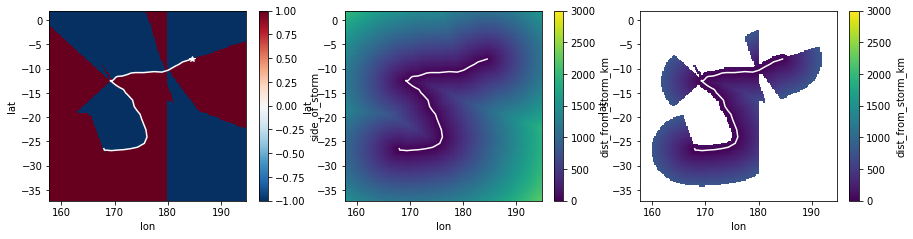

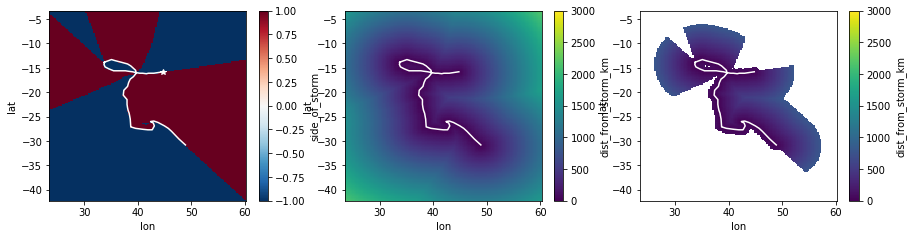

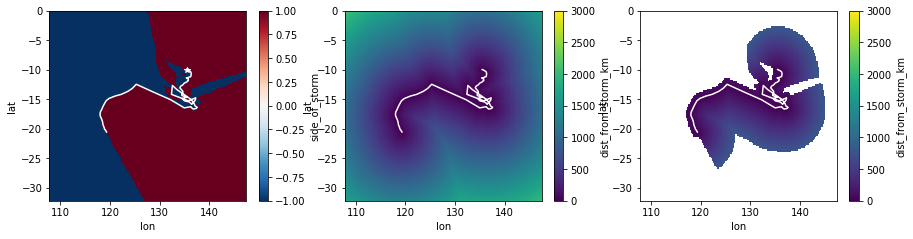

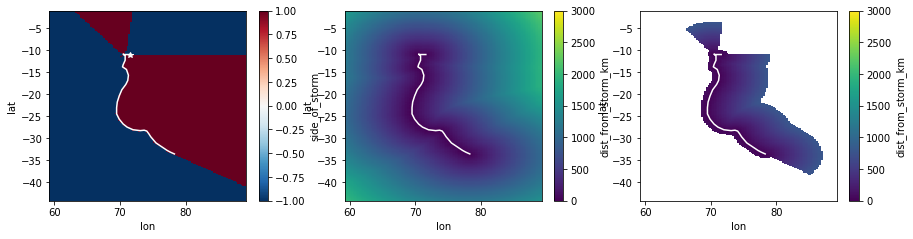

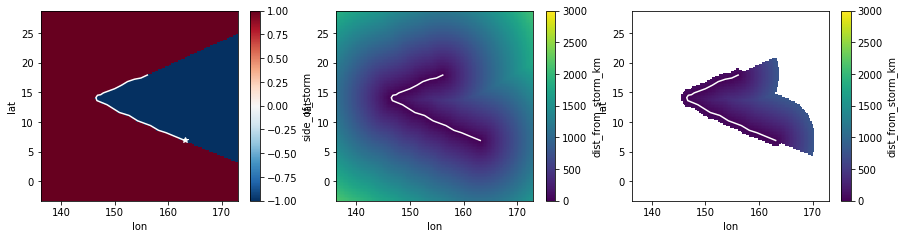

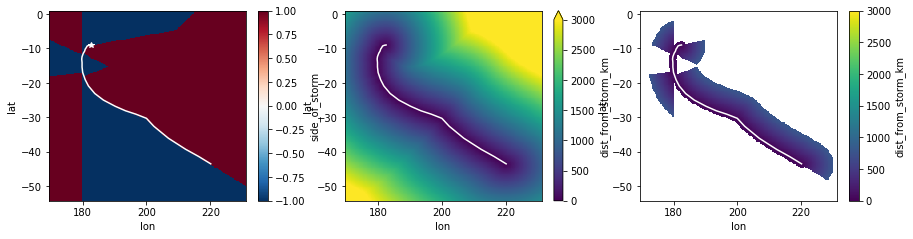

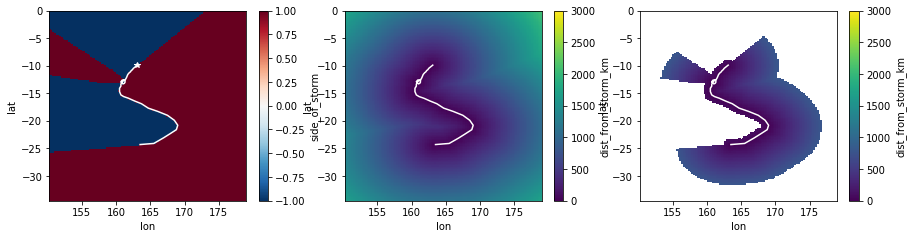

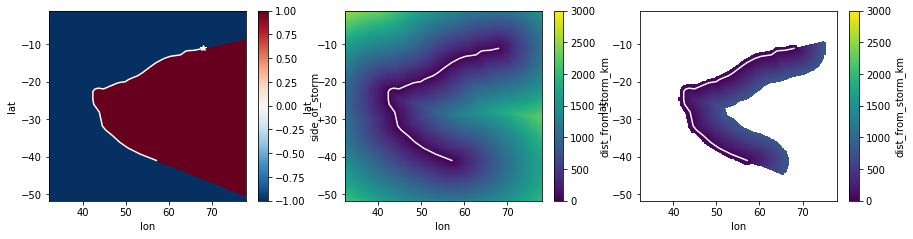

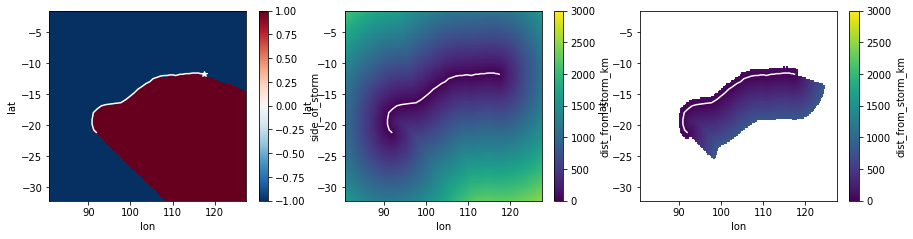

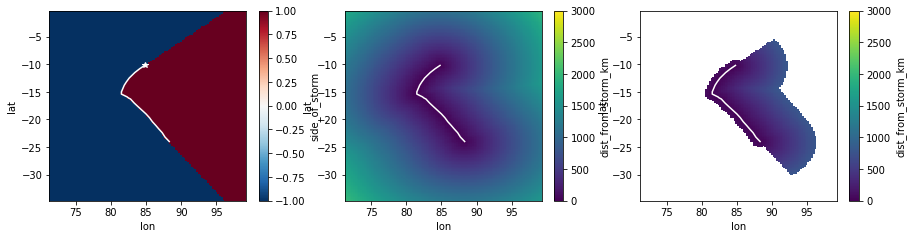

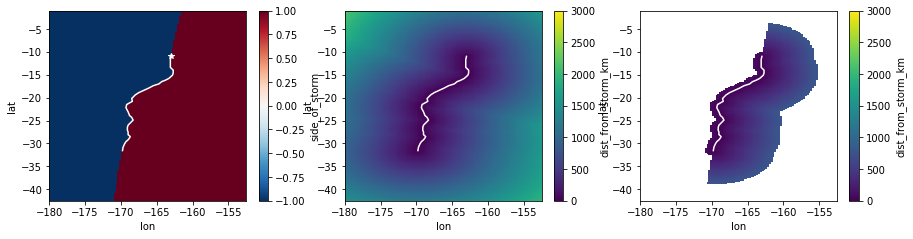

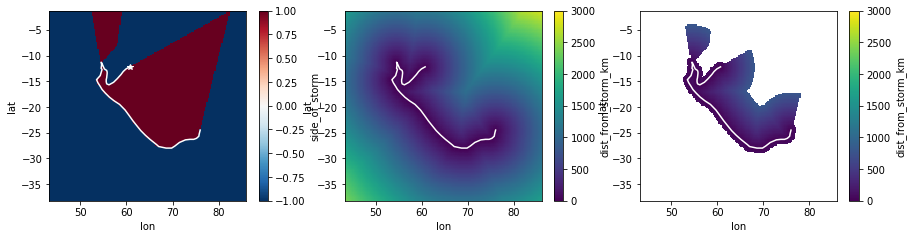

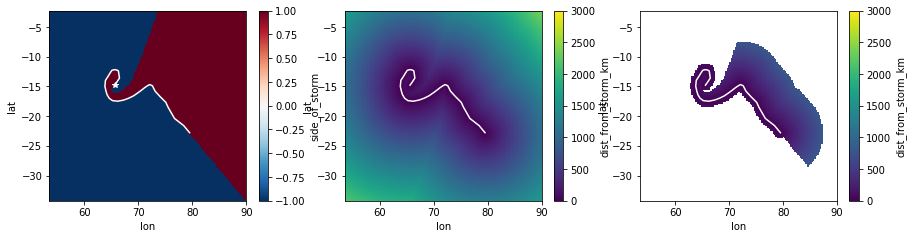

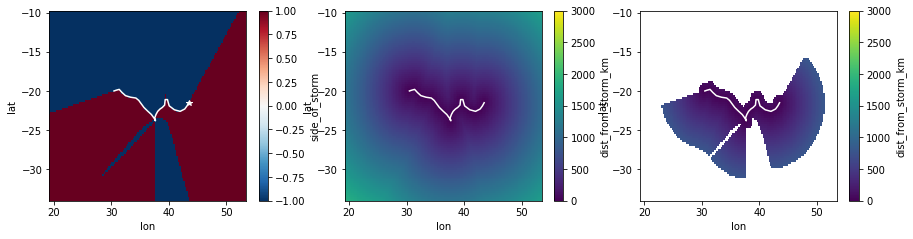

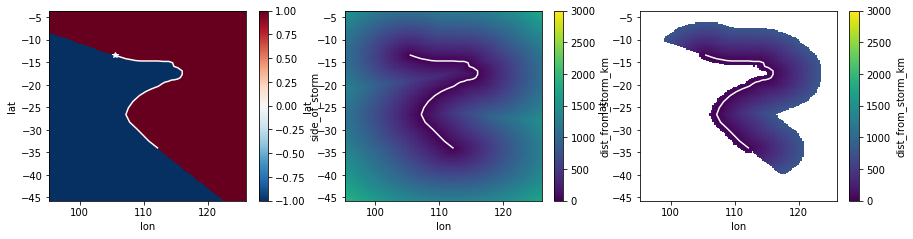

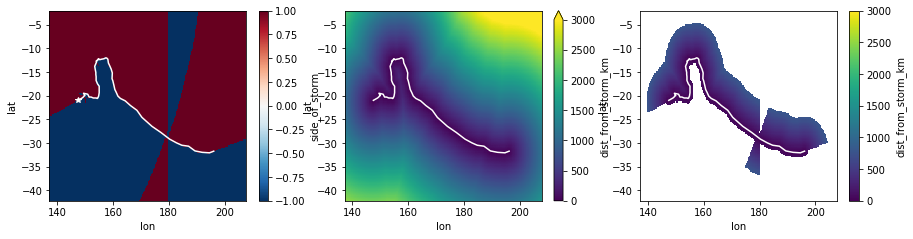

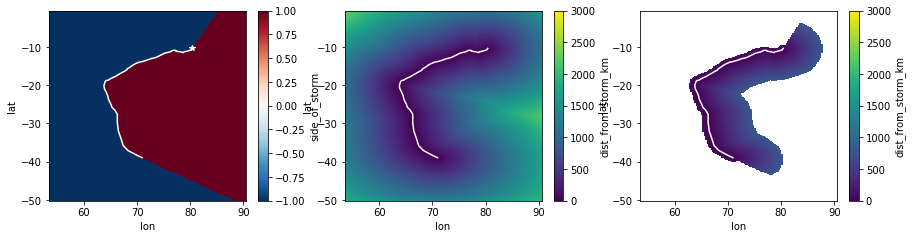

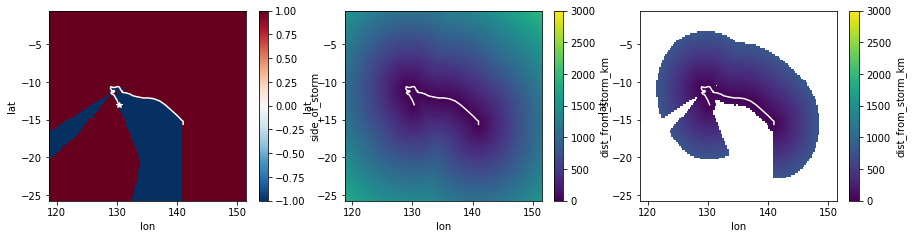

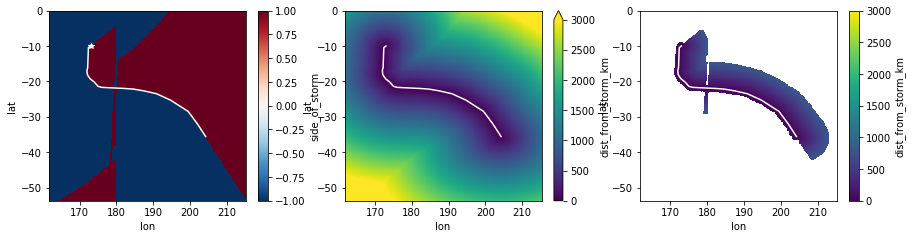

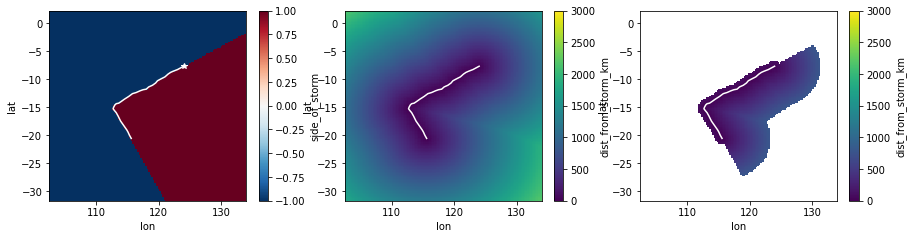

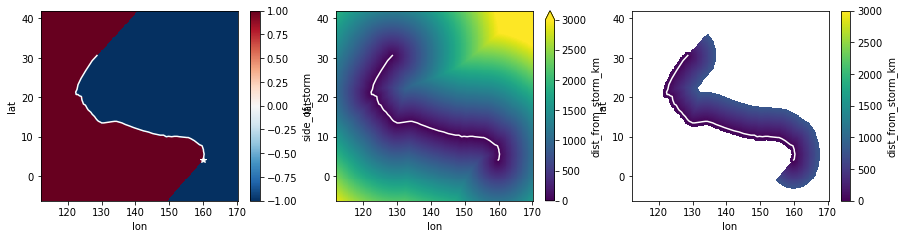

In [65]:
import os
dir_out_figures = 'F:/data/tc_wakes/database/figs/check_storm_dist/'
iyr_storm,inum_storm = 2003,1
for inum_storm in range(1,31): #100):
    filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
    exists = os.path.isfile(filename)
    if not exists:
        continue
    print(filename)
    ds_storm=xr.open_dataset(filename)
    ds_storm = ds_storm.sel(j2=0)
    ds_storm.close()
    filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined__masking_data.nc'
    ds_all = xr.open_dataset(filename)
    ds_all.close()
    #ds_all = ds_all.sortby('lon')
    print(ds_all.lon[0].values,ds_all.lon[-1].values)
    if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
        ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
        #ds_all = ds_all.sortby(ds_all.lon)
        ds_storm['lon'] = np.mod(ds_storm['lon'], 360)
        #ds_storm = ds_storm.sortby(ds_storm.lon)
    plt.figure(figsize=(15,3.5))
    plt.subplot(131)
    ds_all.side_of_storm.plot()
    plt.plot(ds_storm.lon,ds_storm.lat,'w')
    plt.plot(ds_storm.lon[0],ds_storm.lat[0],'w*')
    plt.subplot(132)
    ds_all.dist_from_storm_km.plot(vmin=0,vmax=3000)
    plt.plot(ds_storm.lon,ds_storm.lat,'w')
    max_lat = ds_storm.lat.max()
    if max_lat<0:
        cond = ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) |  ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))
    else:
        cond = ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) |  ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))
    subset = ds_all.where(cond)
    plt.subplot(133)
    subset.dist_from_storm_km.plot(vmin=0,vmax=3000)
    plt.plot(ds_storm.lon,ds_storm.lat,'w')
    filename = dir_out_figures + str(iyr_storm) + str(inum_storm).zfill(3) + '_interpolated_track.png'
    plt.savefig(filename,dpi=100,bbox_inches='tight')
